# Generative Adversarial Networks

&copy; 李浩东 3190104890@zju.edu.cn

- Review
- Pokemon Generation
- Style Transfer


## Review (~2021)

|Common GAN variants and extensions	|Application area|
|:-----:|:-----:|
|DCGAN(Radford et al., 2016)	|Image Generation|
|cGAN(Mirza and Osindero, 2014)	|Semi supervised conditional Image Generation|
|InfoGAN(Chen et al., 2016)	|Unsupervised learning of interpretable and disentangled representations|
|StackGAN(Zhang et al., 2017)	|Image generation based on text inputs|
|Pix2Pix(Isola et al., 2017)	|Image to image translation|
|CycleGAN(Zhu et al., 2017)	|Unpaired Image to image translation|
|StyleGAN(Karras et al., 2020)	|High resolution facial image generation that are diverse in nature|
|RGAN, RCGAN(Esteban et al., 2017)	|Synthetic medical time series data generation|
|TimeGAN(Yoon et al., 2019)	|Realistic time-series data generation|

- A schematic view of variants of GAN. $c$ represents the conditional vector. In `CGAN` and `ACGAN`, $c$ is the discrete categorical code (e.g. one hot vector) that encodes class labels and in `InfoGAN` it can also be continuous code that encodes attributes. $x_g$ generally refers to the generated image but can also be internal representations as in `SGAN`.

![gan_1](./images/8/gan_1.png)

- `cGAN` frameworks for image-to-image translation. `pix2pix` requires aligned training data whereas this constraint is relaxed in `CycleGAN` but usually suffers from performance loss. Note that in (a), we chose reconstruction loss as an example of target consistency. This supervision is task related and can take many other different forms. (c) It consists of two `VAEGAN`s with shared latent vector in the `VAE` part.

![gan_2](./images/8/gan_2.png)

**Pix2pix:  [Project](https://phillipi.github.io/pix2pix/) |  [Paper](https://arxiv.org/pdf/1611.07004.pdf) |  [Torch](https://github.com/phillipi/pix2pix) |
[Tensorflow Core Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix) | [PyTorch Colab](https://colab.research.google.com/github/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/pix2pix.ipynb)**

![gan_3](./images/8/gan_3.png)

**CycleGAN: [Project](https://junyanz.github.io/CycleGAN/) |  [Paper](https://arxiv.org/pdf/1703.10593.pdf) |  [Torch](https://github.com/junyanz/CycleGAN) |
[Tensorflow Core Tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan) | [PyTorch Colab](https://colab.research.google.com/github/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/CycleGAN.ipynb)**

![gan_3](./images/8/gan_4.png)

![horse2zebra.gif](./images/8/horse2zebra.gif)

![gan_3](./images/8/gan_5.png)

- We propose an alternative generator architecture for
generative adversarial networks, borrowing from style
transfer literature. The new architecture leads to an automatically learned, unsupervised separation of **high-level
attributes (e.g., pose and identity when trained on human
faces) and stochastic variation in the generated images
(e.g., freckles, hair)**, and it enables intuitive, scale-specific
control of the synthesis. The new generator improves the
state-of-the-art in terms of traditional distribution quality
metrics, leads to **demonstrably better interpolation properties, and also better disentangles the latent factors of variation**. To quantify interpolation quality and disentanglement,
we propose two new, automated methods that are applicable to any generator architecture. Finally, we introduce a
new, highly varied and high-quality dataset of human faces.
- Paper: https://arxiv.org/abs/1812.04948
- Video: https://youtu.be/kSLJriaOumA
- Code: https://github.com/NVlabs/stylegan
- FFHQ: https://github.com/NVlabs/ffhq-dataset



- Copying a specified subset of styles from source B and taking the rest from source A. 
- Copying the styles corresponding to **coarse spatial resolutions** $(4^2– 8^2)$ brings high-level aspects such as **pose, general hair style, face shape, and yeglasses from source B** while all **colors (eyes, hair, lighting) and finer facial features resemble A** 
- If we instead copy the styles of **middle resolutions** $(16^2– 32^2)$ from B, we inherit **smaller scale facial features, hair style, eyes open/closed from B** while the **pose, general face shape, and eyeglasses from A** are preserved.
- Finally, copying the **fine styles** $(64^2– 1024^2)$ from **B brings mainly the color scheme and microstructure**

![gan_3](./images/8/gan_6.png)

## Pokemon Generation


In [1]:
import warnings
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

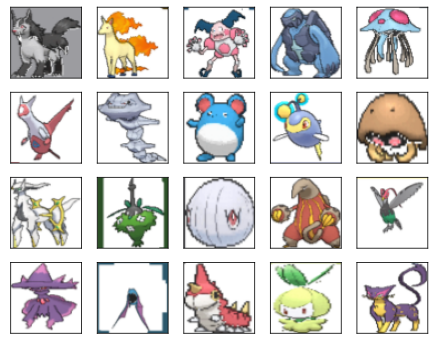

In [2]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

### The Generator and Discriminator

In [5]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8,
            strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)

In [6]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))
    
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)

### Training

In [7]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

loss_D 0.041, loss_G 6.817, 1155.7 examples/sec on cuda:0


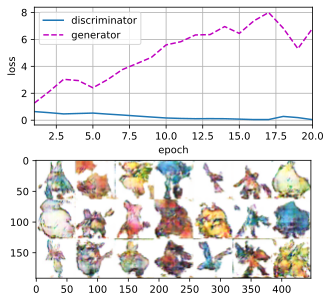

In [8]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

## Style Transfer

In [1]:
import tensorflow as tf
import os
import numpy as np
import PIL.Image


def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


def load_img(path_to_img, max_dim):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

2023-03-13 14:39:48.582924: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Model

In [2]:
def vgg_layers(layer_names):
    """Creates a vgg model that returns a list of intermediate output values."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model


def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)


class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (
            outputs[: self.num_style_layers],
            outputs[self.num_style_layers :],
        )

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {
            content_name: value
            for content_name, value in zip(self.content_layers, content_outputs)
        }

        style_dict = {
            style_name: value
            for style_name, value in zip(self.style_layers, style_outputs)
        }

        return {"content": content_dict, "style": style_dict}

### Training

In [3]:
def style_transfer_image(content, style, epochs=10, steps_per_epoch=100, style_weight=1e-2,
    content_weight=1e4, total_variation_weight=30, max_dim=1000, save_name="output.png"):
    content_img = load_img(content, max_dim=max_dim)
    style_img = load_img(style, max_dim=max_dim)

    content_layers = ["block5_conv2"]

    style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)

    extractor = StyleContentModel(style_layers, content_layers)

    style_targets = extractor(style_img)["style"]
    content_targets = extractor(content_img)["content"]

    image = tf.Variable(content_img)

    def clip_0_1(image):
        return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    def style_content_loss(outputs):
        style_outputs = outputs["style"]
        content_outputs = outputs["content"]
        style_loss = tf.add_n(
            [
                tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                for name in style_outputs.keys()
            ]
        )
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n(
            [
                tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                for name in content_outputs.keys()
            ]
        )
        content_loss *= content_weight / num_content_layers
        loss = style_loss + content_loss
        return loss

    @tf.function()
    def train_step(image):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs)
            loss += total_variation_weight * tf.image.total_variation(image)

        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))
        return loss

    for n in range(epochs):
        for m in range(steps_per_epoch):
            print(f"Epoch: {n+1}/{epochs}, \t\t\tStep:", m + 1, " of ", steps_per_epoch, end="\r")
            train_step(image)
        img = tensor_to_image(image)
        img.save(f"{save_name}_{n}.png")

In [4]:
path = "./8-8-generative-adversarial-networks"
contents = os.listdir(os.path.join(path, "content"))
styles = os.listdir(os.path.join(path, "style"))
os.mkdir(os.path.join(path, "save")) if os.path.exists(os.path.join(path, "save")) is False else None
for C in contents:
    for S in styles:
        print("Training for Content ->", C, " and Style ->", S)
        style_transfer_image(os.path.join(os.path.join(path, "content"), C), 
                             os.path.join(os.path.join(path, "style"), S), 
                             save_name=os.path.join(os.path.join(path, "save"), 
                                                    C.split('.')[0] + '_' + S.split('.')[0]))

Training for Content -> zju_2.jpg  and Style -> art.jpg


2023-03-13 14:39:52.251510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 14:39:52.274229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 14:39:52.274368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 14:39:52.275460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

2023-03-13 14:39:59.091552: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.93GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-13 14:39:59.091582: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.93GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Training for Content -> zju_2.jpg  and Style -> greatwave.jpg
Training for Content -> zju_1.png  and Style -> art.jpg


2023-03-13 14:45:38.347957: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-13 14:45:38.347995: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2023-03-13 14:45:40.893936: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-13 14:45:40.893992: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-13 14:45:41.290411: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-13 14:45:41.290447: W tensorflow/core/common_runtime/bfc_allocato

Training for Content -> zju_1.png  and Style -> greatwave.jpg


<table>
  <tr>
    <td><center><b>Content</b></center></td>
     <td><center><b>Style</b></center></td>
     <td><center><b>Output</b></center></td>
  </tr>
  <tr>
    <td><img src="./8-8-generative-adversarial-networks/content/zju_2.jpg" width=400 ></td>
    <td><img src="./8-8-generative-adversarial-networks/style/art.jpg" width=400 ></td>
    <td><img src="./8-8-generative-adversarial-networks/save/zju_2_art_9.png" width=400 ></td>
  </tr>
 </table>

<table>
  <tr>
    <td><center><b>Content</b></center></td>
     <td><center><b>Style</b></center></td>
     <td><center><b>Output</b></center></td>
  </tr>
  <tr>
    <td><img src="./8-8-generative-adversarial-networks/content/zju_2.jpg" width=400 ></td>
    <td><img src="./8-8-generative-adversarial-networks/style/greatwave.jpg" width=400 ></td>
    <td><img src="./8-8-generative-adversarial-networks/save/zju_2_greatwave_9.png" width=400 ></td>
  </tr>
 </table>

<table>
  <tr>
    <td><center><b>Content</b></center></td>
     <td><center><b>Style</b></center></td>
     <td><center><b>Output</b></center></td>
  </tr>
  <tr>
    <td><img src="./8-8-generative-adversarial-networks/content/zju_1.png" width=400 ></td>
    <td><img src="./8-8-generative-adversarial-networks/style/art.jpg" width=400 ></td>
    <td><img src="./8-8-generative-adversarial-networks/save/zju_1_art_9.png" width=400 ></td>
  </tr>
 </table>

<table>
  <tr>
    <td><center><b>Content</b></center></td>
     <td><center><b>Style</b></center></td>
     <td><center><b>Output</b></center></td>
  </tr>
  <tr>
    <td><img src="./8-8-generative-adversarial-networks/content/zju_1.png" width=400 ></td>
    <td><img src="./8-8-generative-adversarial-networks/style/greatwave.jpg" width=400 ></td>
    <td><img src="./8-8-generative-adversarial-networks/save/zju_1_greatwave_9.png" width=400 ></td>
  </tr>
 </table>